In [8]:
!pip install requests pandas scikit-learn

In [9]:
# Install required libraries (if not already installed)
!pip install requests numpy tensorflow 

import requests
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

In [20]:
from dotenv import load_dotenv
load_dotenv()

True

In [47]:
import os
!pip install folium flask_cors


  Obtaining dependency information for flask_cors from https://files.pythonhosted.org/packages/85/61/4aea5fb55be1b6f95e604627dc6c50c47d693e39cab2ac086ee0155a0abd/flask_cors-5.0.1-py3-none-any.whl.metadata
Using cached flask_cors-5.0.1-py3-none-any.whl (11 kB)


In [22]:
%pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import requests
import joblib
import os
import folium
from geopy.geocoders import Nominatim
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


ModuleNotFoundError: No module named 'gradio'

In [53]:


def load_influenza_data(file_path="influenza_data.csv"):
    try:
        df = pd.read_csv(file_path)
        required_columns = {"temperature_c", "humidity_pct", "pressure_hpa", "rainfall_mm", "age", "symptom_days", "influenza_positive"}
        
        if not required_columns.issubset(df.columns):
            raise ValueError("Missing required columns in influenza dataset!")
        
        return df
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None

def get_weather_data(city, api_key=None):
    if not api_key:
        return {
            "temperature_c": 22.0,
            "humidity_pct": 70,
            "pressure_hpa": 1012,
            "rainfall_mm": 5.0
        }
    
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric"
    try:
        response = requests.get(url).json()
        return {
            "temperature_c": response["main"]["temp"],
            "humidity_pct": response["main"]["humidity"],
            "pressure_hpa": response["main"]["pressure"],
            "rainfall_mm": response.get("rain", {}).get("1h", 0)
        }
    except:
        return get_weather_data(city, None)

def get_country_coordinates(country):
    """Gets latitude and longitude for a given country."""
    geolocator = Nominatim(user_agent="geoapi")
    location = geolocator.geocode(country)
    return (location.latitude, location.longitude) if location else (None, None)

def plot_disease_risk_on_map(country, risk_percentage):
    """Plots influenza outbreak risk on a map."""
    lat, lon = get_country_coordinates(country)
    if lat is None or lon is None:
        print(f"Could not find coordinates for {country}")
        return
    
    world_map = folium.Map(location=[lat, lon], zoom_start=3)
    folium.Marker(
        [lat, lon], 
        popup=f"{country}: {risk_percentage:.2f}% Risk", 
        icon=folium.Icon(color="red")
    ).add_to(world_map)
    world_map.save("influenza_risk_map.html")
    print("Map saved as influenza_risk_map.html")

def train_model():
    df = load_influenza_data()
    if df is None:
        return None

    X = df.drop(columns=["influenza_positive"])
    y = df["influenza_positive"]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train, y_train)

    return model, scaler

def predict_influenza(country="USA"):
    api_key = os.getenv("OPENWEATHERMAP_API_KEY")
    weather = get_weather_data(country, api_key)

    model, scaler = train_model()
    if model is None:
        return "Model training failed."

    # Prepare new data sample
    X_new = pd.DataFrame([{
        "temperature_c": weather["temperature_c"],
        "humidity_pct": weather["humidity_pct"],
        "pressure_hpa": weather["pressure_hpa"],
        "rainfall_mm": weather["rainfall_mm"],
        "age": 35,  
        "symptom_days": 2 
    }])

    X_new_scaled = scaler.transform(X_new)
    risk_prediction = model.predict_proba(X_new_scaled)[0][1] * 100  

    plot_disease_risk_on_map(country, risk_prediction)
    return risk_prediction



In [54]:
print(predict_influenza(country='Indonesia'))

c:\Users\siddh\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:23:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Map saved as influenza_risk_map.html
5.860697850584984


In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS

app = Flask(__name__)
CORS(app, resources={r"/*":{"origins":"*"}})

@app.route('/upload', methods=['POST'])
def upload():
    data = request.get_json()  # Expecting JSON with a key called 'text'

    if not data or 'text' not in data:
        return jsonify({'error': 'No text provided'}), 400

    input_text = data['text']

    result = predict_influenza(input_text)
    print(result)
    return jsonify({
        'original': input_text,
        'output': result,
    })
app.run(port=5000, use_reloader=False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [06/May/2025 11:24:36] "OPTIONS /upload HTTP/1.1" 200 -
127.0.0.1 - - [06/May/2025 11:24:39] "POST /upload HTTP/1.1" 200 -


Map saved as influenza_risk_map.html


c:\Users\siddh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\siddh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
c:\Users\siddh\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


Mean Squared Error: 18.87


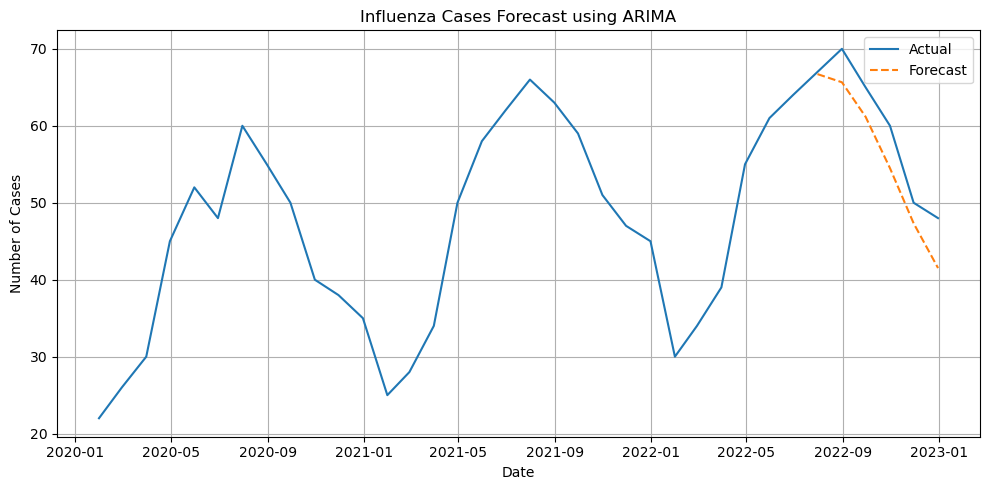

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Example: Simulated monthly influenza cases
data = {
    'Month': pd.date_range(start='2020-01-01', periods=36, freq='M'),
    'Cases': [22, 26, 30, 45, 52, 48, 60, 55, 50, 40, 38, 35,
              25, 28, 34, 50, 58, 62, 66, 63, 59, 51, 47, 45,
              30, 34, 39, 55, 61, 64, 67, 70, 65, 60, 50, 48]
}

df = pd.DataFrame(data)
df.set_index('Month', inplace=True)

# Split into train and test
train = df.iloc[:30]
test = df.iloc[30:]

# Fit ARIMA model (p=2, d=1, q=2) — you can tune this
model = ARIMA(train['Cases'], order=(2, 1, 2))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluation
mse = mean_squared_error(test['Cases'], forecast)
print(f'Mean Squared Error: {mse:.2f}')

# Plot
plt.figure(figsize=(10,5))
plt.plot(df.index, df['Cases'], label='Actual')
plt.plot(test.index, forecast, label='Forecast', linestyle='--')
plt.title('Influenza Cases Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
